# Post Processing

This notebook aims to address N/A Values and duplicates, an oversight from the first analysis. Here, we binary encoded category variables that are relevant to this analysis. I've also log-transformed and cube-transformed numeric variables review_counts and ratings in preparation for statistical analysis.



In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Dependencies
import icecream as ic
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


# Data Preprocessing
TODO: For later, impute prices to build model


In [23]:
# Import dataframe
df_main = pd.read_csv('../Resources/nyc_bakeries_aggregated.csv', index_col='Unnamed: 0')

# Convert phone and display phone to bools
df_main['phone'] = df_main['phone'].apply(lambda x: False if pd.isna(x) else True).astype(int)
df_main['display_phone'] = df_main['display_phone'].apply(lambda x: False if pd.isna(x) else True).astype(int)

# Encode Nominal Cat Variables
cost_dict = {
    '$': 1,
    '$$': 2,
    '$$$': 3,
    '$$$$': 4}
df_main['price'] = df_main['price'].map(cost_dict)
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6372 entries, 0 to 23444
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6372 non-null   object 
 1   name           6372 non-null   object 
 2   review_count   6372 non-null   int64  
 3   category       6372 non-null   object 
 4   rating         6372 non-null   float64
 5   phone          6372 non-null   int64  
 6   display_phone  6372 non-null   int64  
 7   price          4276 non-null   float64
 8   coord_lat      6372 non-null   float64
 9   coord_long     6372 non-null   float64
dtypes: float64(4), int64(3), object(3)
memory usage: 547.6+ KB


In [24]:
# Bin category that has a frequency less than 50
cat_counts = df_main.category.value_counts()
cat_filtered = cat_counts[cat_counts < 50].index
df_main['category'] = df_main['category'].replace(cat_filtered, 'Other')

In [25]:
# Aggregate columns
df_cat_agg = df_main.groupby('id')['category'].agg(', '.join).reset_index()
df_cat_agg.columns = ['id', 'categories']

# Left join on id's and drop duplicates
df_main = pd.merge(df_main, df_cat_agg, on='id', how='left')
df_main.drop_duplicates('id', inplace=True)
df_main.head()

,id,name,review_count,category,rating,phone,display_phone,price,coord_lat,coord_long,categories
0,epvSBt9LldIgyc08f8nIAw,La Bicyclette Bakery,3,bakeries,4.5,0,0,NaN,40.683587,-73.995090,bakeries
1,-k_5NsYnKCHGTdBaqegkrw,Le Fournil,118,bakeries,4.5,0,0,2.0,40.727947,-73.988489,bakeries
2,0kW0112jMERVjpRzWT4F7Q,La Bicyclette Bakery,84,bakeries,5.0,1,1,NaN,40.714400,-73.959110,bakeries
3,XSwagBljEsxG2i1rq4GEAQ,Almondine Bakery,404,bakeries,4.0,1,1,2.0,40.703317,-73.991251,bakeries
4,fPQ2eE9lm8tc87O5-GLjyA,Mille-Feuille Bakery,441,coffee,4.5,1,1,2.0,40.782425,-73.981160,"coffee, bakeries"


In [26]:
# Look at category types and replace redundant ie coffee and cafes
df_main['category'].value_counts()
df_main['category'] = df_main['category'].replace('coffee', 'cafes')

In [27]:
# Preview final counts
df_main['category'].value_counts()

category
bakeries            796
cafes               566
Other               448
desserts            268
icecream            127
donuts              104
french               68
cakeshop             61
bubbletea            53
breakfast&brunch     49
italian              38
bagels               37
newamerican          35
chocolate            31
cupcakes             26
sandwiches           22
cocktailbars          7
Name: count, dtype: int64

In [28]:
# Drop id and name for analysis, save for later
identifiers = df_main[['id', 'name']]
df_main_mod = df_main.copy()
df_main_mod.drop(['category'], axis=1, inplace=True)

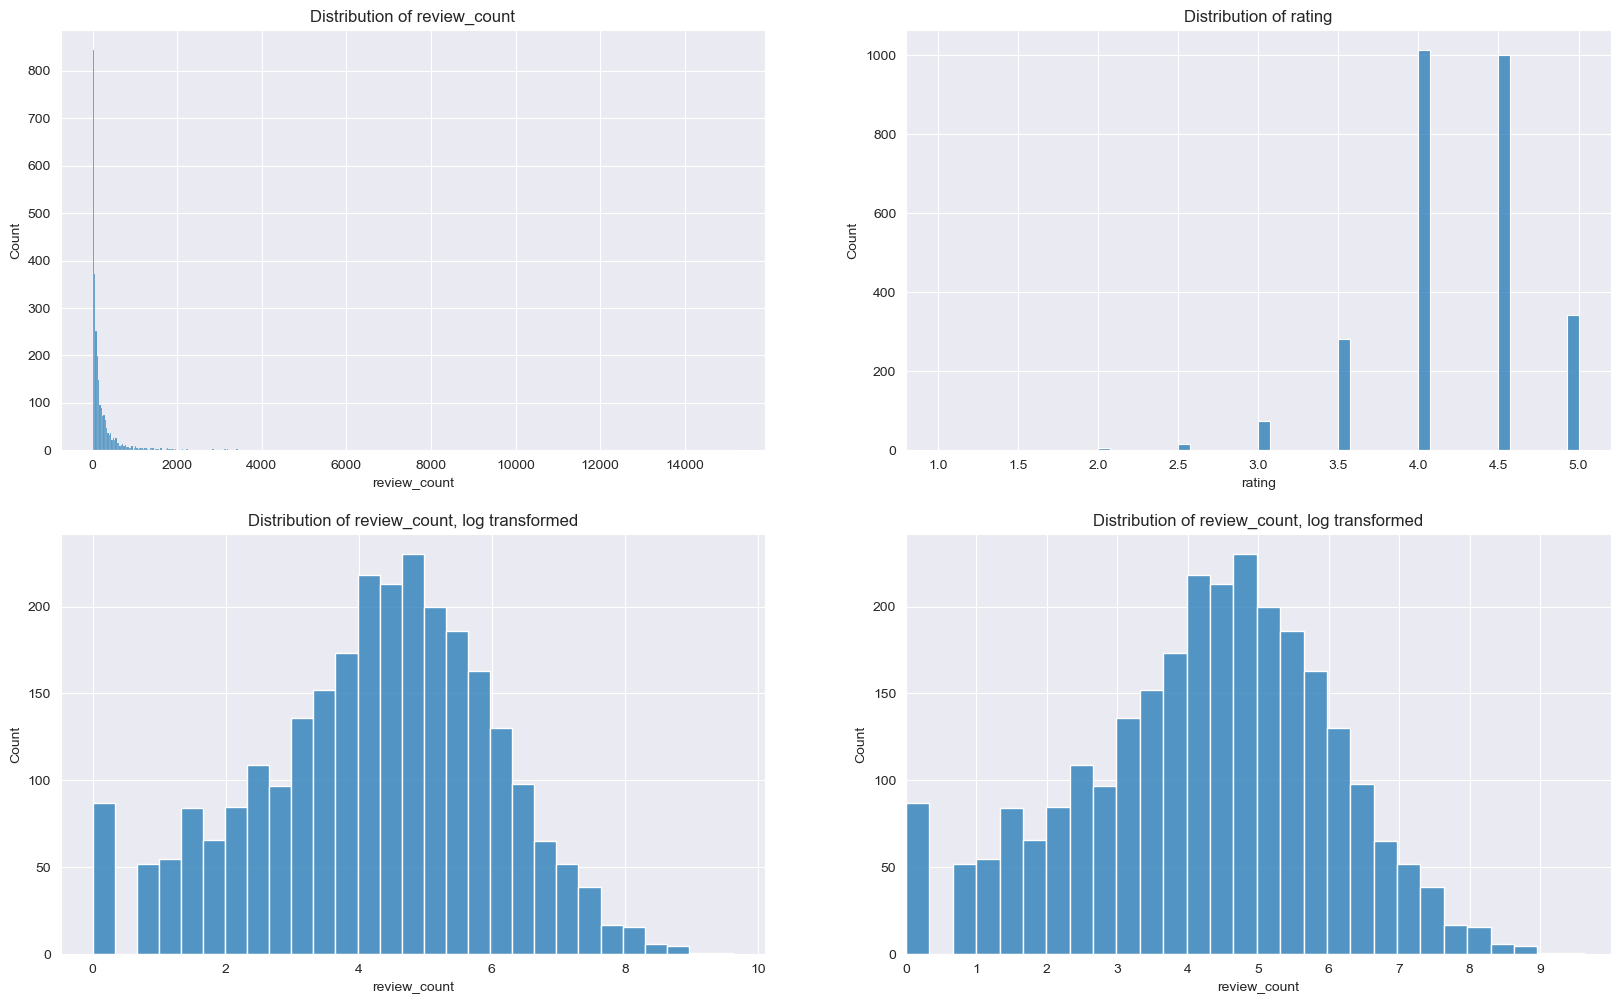

In [29]:
# Observe distribution and scale data
# Observe review_counts
# Plot distribution of review_counts
fig, ax = plt.subplots(2,2, figsize=(20,12))
sns.histplot(df_main['review_count'], ax=ax[0,0])
ax[0,0].set_title('Distribution of review_count')
plt.xlim(0, 2500)
plt.xticks(np.arange(0, 2500, 500))
# Log transformation of review_counts
df_main_mod['review_count'] = np.log(df_main['review_count'])
sns.histplot(df_main_mod['review_count'], ax=ax[1,0])
ax[1,0].set_title('Distribution of review_count, log transformed')
plt.xlim(0, 10)
plt.xticks(np.arange(0, 10, 1))

# Observe average review
sns.histplot(df_main['rating'], ax=ax[0,1])
ax[0,1].set_title('Distribution of rating')
plt.xlim(0, 6)
plt.xticks(np.arange(0, 5.5, 0.5))
# Cube transformation of review_counts
df_main_mod['rating'] = np.square(df_main['rating'])
sns.histplot(df_main_mod['review_count'], ax=ax[1,1])
ax[1,1].set_title('Distribution of review_count, log transformed')
plt.xlim(0, 10)
plt.xticks(np.arange(0, 10, 1))

plt.show()

In [20]:
# Encoding categories
def business_category_encoder(df, rel_categories):
    for cat in rel_categories:
        df[f'is_{cat}'] = df['categories'].str.contains(cat).astype('int')
    df.drop('categories', axis=1, inplace=True)
    return df

In [30]:
# Execute encoder
relevant_categories = ['bakeries', 'desserts',
                       'icecream', 'cafe', 'donuts',
                       'cakeshop', 'bubbletea', 'chocolate',
                       'cupcakes', 'Other']
df_main_mod = business_category_encoder(df_main_mod, relevant_categories)
df_main_mod.head()

,id,name,review_count,rating,phone,display_phone,price,coord_lat,coord_long,is_bakeries,is_desserts,is_icecream,is_cafe,is_donuts,is_cakeshop,is_bubbletea,is_chocolate,is_cupcakes,is_Other
0,epvSBt9LldIgyc08f8nIAw,La Bicyclette Bakery,1.098612,20.25,0,0,NaN,40.683587,-73.995090,1,0,0,0,0,0,0,0,0,0
1,-k_5NsYnKCHGTdBaqegkrw,Le Fournil,4.770685,20.25,0,0,2.0,40.727947,-73.988489,1,0,0,0,0,0,0,0,0,0
2,0kW0112jMERVjpRzWT4F7Q,La Bicyclette Bakery,4.430817,25.00,1,1,NaN,40.714400,-73.959110,1,0,0,0,0,0,0,0,0,0
3,XSwagBljEsxG2i1rq4GEAQ,Almondine Bakery,6.001415,16.00,1,1,2.0,40.703317,-73.991251,1,0,0,0,0,0,0,0,0,0
4,fPQ2eE9lm8tc87O5-GLjyA,Mille-Feuille Bakery,6.089045,20.25,1,1,2.0,40.782425,-73.981160,1,0,0,0,0,0,0,0,0,0


In [31]:
# Export
df_main_mod.to_csv('../Resources/post_processed_bakeries.csv')